In [1]:
import pandas as pd
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from  sklearn.linear_model import LogisticRegression
import re
import seaborn as sns

In [2]:
train_original = pd.read_csv('data/train.csv')
test_original = pd.read_csv('data/test.csv')

# Preprocessing

Obtain expected values from dataset

In [3]:
y = train_original.pop('Survived')

We can foresee that columns 'Pclass' and 'Fare' are highly correlated with 'Survived' hence they will be important for the model

/var/folders/57/x0b9lln16kqfwvd_m3xb97rm0000gn/T/ipykernel_9755/2457345379.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(pd.concat((y, train_original), axis=1).corr(), annot=True, cmap='viridis')


<Axes: >

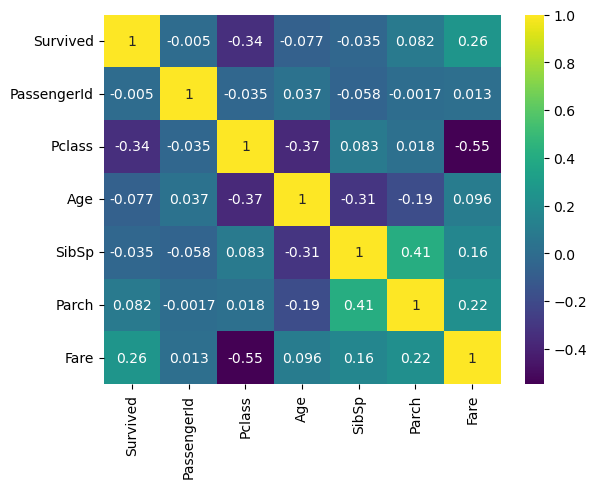

In [4]:
sns.heatmap(pd.concat((y, train_original), axis=1).corr(), annot=True, cmap='viridis')

## Fill or remove undefined data

We print the amount of missing data in the dataset.

Then we can remove the Cabin column since there is more than half the data missing, for the Age, Fare, and Embarked columns we can impute those values

In [5]:
def check_for_nulls(df):
  print('')
  print('**************')
  nulls = (df.isnull().sum())
  nulls = nulls[nulls > 0] 
  if len(nulls) > 0:
    print(nulls)
  else:
    print('No nulls values found')
  print('total: ', len(df))
check_for_nulls(train_original)
check_for_nulls(test_original)


**************
Age         177
Cabin       687
Embarked      2
dtype: int64
total:  891

**************
Age       86
Fare       1
Cabin    327
dtype: int64
total:  418


In [6]:
def remove_columns(df):
  remove_cols = ['PassengerId', 'Cabin']
  return df[[col for col in df.columns if col not in remove_cols]]

In [7]:
def create_imputer(df):
  my_imputer = SimpleImputer(strategy='most_frequent')
  columns_to_impute = ['Age', 'Embarked', 'Fare']
  my_imputer.fit(df[columns_to_impute])
  def imputer(df):
    df = df.copy()
    data_with_imputed_values = my_imputer.transform(df[columns_to_impute])
    df_imputed = pd.DataFrame(data=data_with_imputed_values, columns=columns_to_impute)
    df_imputed.Age = df_imputed.Age.astype('float32')
    df[columns_to_impute] = df_imputed
    return df
  return (imputer(df), imputer)


In [8]:
def extract_person_title(df):
  """
  Removes the column 'Name' and replace it for
  column 'Title' containing the tile of in the name
  example 'Mr.' or 'Master.'
  """
  df = df.copy()
  df['Title'] = df.pop('Name').apply(lambda x: re.search('(?<=,\s).*?\.', x).group(0))
  return df

In [9]:
def hot_encoding(df, columns=None):
  """
  hot encode columns in df
  if columns paramenter is given, the returned dataframe has
  those columns. That is used to make sure that the columns in
  the test dataset are the same as the ones in the train dataset.
  """
  df = df.copy()
  hot_encodings = []
  for col in ['Ticket', 'Sex', 'Embarked', 'Title']:
    hot_encoding = pd.get_dummies(df.pop(col))
    # remove the last column which is reduntant
    hot_encoding = hot_encoding.iloc[:, :-1]
    hot_encodings.append(hot_encoding)
  df = pd.concat([df, *hot_encodings], axis=1)
  if columns is not None and len(columns) > 0:
    df = df.reindex(columns=columns,fill_value=0)
  return df

In [10]:
def normalize_data(df, scaler=None):
  if scaler is None:
    scaler = MinMaxScaler()
    scaler = scaler.fit(df)
  scaled_data = scaler.transform(df)
  print(type(scaled_data))
  print(scaled_data.dtype)
  print(scaled_data.shape)
  df = pd.DataFrame(scaled_data, columns=df.columns)
  return df, scaler
  

function 'preprocessing' concatenates all the previous functions into one

In [11]:
def preprocessing(df, mode='train', imputer=None, columns=None, scaler=None):
  if mode != 'train' and not callable(imputer): 
    raise Exception('if you are not training, you need to provide an imputer for the data')
  df = remove_columns(df)
  if mode == 'train':
    df, imputer = create_imputer(df)
  else:
    df = imputer(df)
  df = extract_person_title(df)
  df = hot_encoding(df, columns=columns)
  if mode == 'train':
    df, scaler = normalize_data(df)
  else:
    df, _ = normalize_data(df, scaler)
  return df, imputer

In [12]:
train, imputer = preprocessing(train_original)

<class 'numpy.ndarray'>
float64
(891, 704)


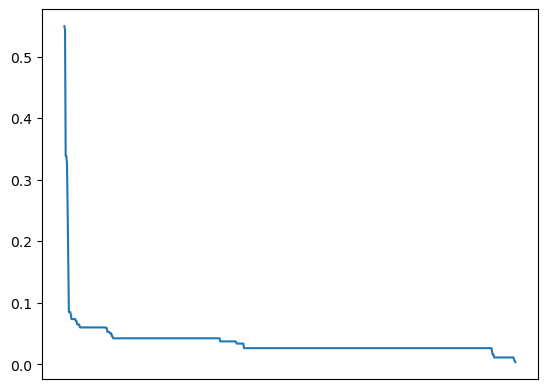

In [13]:
y_corr = pd.concat((y, train), axis=1).corr().Survived.abs().sort_values(ascending=False)
plt.figure(1)
plt.plot(y_corr[1:])
plt.xticks([])
plt.show()

We can see that most of the 704 columns are not that much correlated to the 'Survived' Columns.
We could try for example to obtain just the most 300 correlated columns to avoid overfitting the model
In this dataset however, the best score when submitting the answers was when all the columns were had into account.
Hence why the line to reindex the train dataset is commented

In [14]:
y_corr_significant = y_corr.iloc[1:301]
#train = train.reindex(columns=y_corr_significant.index,fill_value=0)

In [15]:
test, _ = preprocessing(test_original, mode='test', imputer=imputer, columns=train.columns)

<class 'numpy.ndarray'>
float64
(418, 704)


We make sure there are no missin values in the train and test dataframe

In [16]:
check_for_nulls(train)
check_for_nulls(test)


**************
No nulls values found
total:  891

**************
No nulls values found
total:  418


# Model

## Divide training data into training and validating data

In [17]:
l = train.shape[0] // 4

val_data = train[:l]
val_y = y[:l]
train_data = train[l:]
train_y = y[l:]


## Create model

In [18]:
model = LogisticRegression(max_iter=1000, verbose=0)
model.fit(train_data,train_y)
# model.fit(train,y)

LogisticRegression(max_iter=1000)

In [19]:
print('model score in train data: ', model.score(train_data, train_y))
print('model score in validation data: ', model.score(val_data, val_y))

model score in train data:  0.9043348281016442
model score in validation data:  0.8468468468468469


## Predict Tests outputs

In [20]:
def get_prediction(md, v_data):
  val_prediction = md.predict(v_data)
  val_prediction[val_prediction >= 0.5] = 1
  val_prediction[val_prediction < 0.5] = 0
  val_pred = val_prediction.flatten()
  return val_pred

In [21]:
ans = get_prediction(model, test)
print(ans.shape)
ans_df = pd.DataFrame(ans)
ans_df.columns = ['Survived']
ps_id_label = 'PassengerId'
ans_df['Survived'] = ans_df['Survived'].astype(np.int16)
ans_df[ps_id_label] = test_original[ps_id_label]
print(ans_df.head())
print(ans_df.describe())

(418,)
   Survived  PassengerId
0         0          892
1         1          893
2         0          894
3         0          895
4         1          896
         Survived  PassengerId
count  418.000000   418.000000
mean     0.411483  1100.500000
std      0.492692   120.810458
min      0.000000   892.000000
25%      0.000000   996.250000
50%      0.000000  1100.500000
75%      1.000000  1204.750000
max      1.000000  1309.000000


In [22]:
file_name = 'logistic_regression_submission.csv'
ans_df.to_csv(file_name, columns=['PassengerId', 'Survived'], index=False)

In [23]:
!cat $file_name | head

PassengerId,Survived
892,0
893,1
894,0
895,0
896,1
897,0
898,1
899,0
900,1
